In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
from lifelines import KaplanMeierFitter, ExponentialFitter, CoxPHFitter
import time
import scipy.stats
import netgraph
from scipy.special import expit

palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

sns.set_palette(palette)

In [ ]:
def build_network(G):
    A = nx.to_numpy_array(G).astype(np.float64)
    n = A.shape[0]

    d = A.sum(0)

    for i in range(n):
        A[i, i] = 0
        for j in range(i):
            if A[i, j] != 0:
                A[i, j] = 1.0 / max(d[i], d[j])
                A[j, i] = A[i, j]
    
    for i in range(n):
        A[i, i] = 1 - A[i, :].sum()

    return A, n

def load_tmb_data():

    df = pd.read_excel('datasets/41588_2018_312_MOESM3_ESM.xlsx', header=1)

    # sort by TMB

    df = df.sort_values(by='TMB', ascending=False)

    return df

def plot_tmb_data(df):

    indices = {
        'Top 10% (High TMB)' : (0, int(0.1 * len(df))),
        'Top 10-20% (Medium TMB)' : (int(0.1 * len(df)), int(0.2 * len(df))),
        'Bottom 80% (Low TMB)' : (int(0.2 * len(df)), len(df))
    }


    # log-rank tests


    p_values = {}
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    for name, (start, end) in indices.items():
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df['SURVIVAL_MONTHS'].values[start:end], event_observed=df['SURVIVAL_MONTHS'].values[start:end], label=name)
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)

    sns.despine()
    ax.grid(False)
    ax.set_xlim(0, 48)

    ax.set_ylabel('Overall Survival (%)')
    ax.set_xlabel('Time (months)')

    # set x-ticks to 12, 24, 36, 48
    ax.set_xticks([0, 12, 24, 36, 48])

    # ax.set_title('Kaplan-Meier Survival Curve')
    # ax[1].set_title('Exponential Survival Curve')

    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.savefig('figures/survival_curves.pdf', bbox_inches='tight')

    # Cox Proportional Hazard Model

    # df = df.drop

    cph = CoxPHFitter()

    tmb_percentile_cutoffrange = np.arange(1, 60)

    records = []

    for tmb_percentile_cutoff in tmb_percentile_cutoffrange:
        start, end = 0, int(tmb_percentile_cutoff * len(df) / 100)

        cph.fit(df[['SURVIVAL_MONTHS', 'SURVIVAL_EVENT', 'TMB']].iloc[start:end], duration_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', formula='TMB')

        records.append({
            'Hazard Ratio' : cph.hazard_ratios_['TMB'],
            'P-value' : '$P < 0.05$' if cph.summary['p'][0] < 0.05 else '$P \\geq 0.05$',
            'TMB Cutoff' : tmb_percentile_cutoff
        })

    records = pd.DataFrame(records)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.pointplot(x='TMB Cutoff', y='Hazard Ratio', data=records, ax=ax, hue='P-value')

    ax.set_xticks(np.arange(9, 61, 10))
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    sns.despine()

    # ax.set_title('Cox Proportional Hazard Model')

    fig.savefig('figures/cox_proportional_hazard_model.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    cph.fit(df[['SURVIVAL_MONTHS', 'SURVIVAL_EVENT', 'TMB']], duration_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', formula='TMB')

    cph.plot(ax=ax)

df_tmb = load_tmb_data()
plot_tmb_data(df_tmb)


In [ ]:
def load_hiv_data(num_hospitals=10):
    df = pd.read_csv('datasets/atcg_study175/AIDS_ClinicalTrial_GroupStudy175.csv')

    treatment_dic = {
        'ZDV' : 0,
        'ZDV_ddI' : 1,
        'ZDV_Zal' : 2,
        'ddI' : 3
    }

    for key, val in treatment_dic.items():
        df[key] = (df['trt'] == val).astype(np.float64)

    # Assign each patient to a hospital uniformly
    df['Hospital'] = df.index % num_hospitals

    return df

def plot_hiv_data(df):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    treatment_dict = {
        'ZDV' : 0,
        'ZDV_ddI' : 1,
        'ZDV_Zal' : 2,
        'ddI' : 3
    }

    for name, val in treatment_dict.items():
        kmf = KaplanMeierFitter()
        df_trt = df[df['trt'] == val]
        kmf.fit(durations=df_trt['time'], event_observed=df_trt['label'], label=name.replace('_', '+'))
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)

    sns.despine()
    ax.grid(False)

    ax.set_ylabel('Overall Survival (%) / Centralized')
    ax.set_xlabel('Time (days)')

    fig.savefig('figures/survival_curves_hiv.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    for name, val in treatment_dict.items():
        kmf = KaplanMeierFitter()
        df_trt = df.query(f'trt == {val} and Hospital == 1')
        kmf.fit(durations=df_trt['time'], event_observed=df_trt['label'], label=f"{name.replace('_', '+')}")
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)

    sns.despine()
    ax.grid(False)

    ax.set_ylabel('Overall Survival (%) / One Hospital')
    ax.set_xlabel('Time (days)')

    fig.savefig('figures/survival_curves_hiv_one_hospital.pdf', bbox_inches='tight')

    cph = CoxPHFitter()

    cph.fit(df[['time', 'label', 'ZDV_ddI']], duration_col='time', event_col='label', formula='ZDV_ddI')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    cph.plot(ax=ax)

    fig.savefig('figures/cox_proportional_hazard_model_hiv.pdf', bbox_inches='tight')

df_atsg = load_hiv_data()

plot_hiv_data(df_atsg)


In [ ]:
def tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def plot_beliefs_graph(G, A, beliefs, log_belief_ratios, titles, suptitle='', outfile=None, node_layout='circular', t=-1):
        
    fig, ax = plt.subplots(1, len(beliefs), figsize=(3 * len(beliefs), 3))

    cmap = plt.cm.get_cmap('Reds')

    n = len(G)

    for i, belief in enumerate(beliefs):

        node_color = {i: 'white' for i in range(n)}
        edge_color = {(i, j): cmap(A[i, j]) for i, j in G.edges()}

        node_labels = {i: f'{i + 1}\n({belief[i, t]:.2f})' for i in range(n)}
        node_label_fontdict=dict(color='black', weight='bold')

        netgraph.Graph(G, ax=ax[i], node_size=10, edge_width=1.5, node_labels=node_labels, node_label_fontdict=node_label_fontdict, node_color=node_color, edge_color=edge_color, node_layout=node_layout)

        plt.Normalize(vmin=0, vmax=1)

        ax[i].set_title(titles[i])


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)

    fig.suptitle(suptitle)

    fig.tight_layout()

    if outfile is not None:
        fig.savefig(outfile, bbox_inches='tight')

def plot_beliefs_barplot(beliefs, labels, threshold, suptitle='', outfile=None, t=-1):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    records = []

    for i, (belief, label) in enumerate(zip(beliefs, labels)):
        for j in range(belief.shape[0]):
            record = {
                'Hospital' : j + 1,
                'Belief' : belief[j, t],
                'Hypothesis' : label
            }

            records.append(record)

    records = pd.DataFrame(records)

    if threshold:
        ax.axhline(threshold, color='black', linestyle='--', label='Threshold')

    sns.barplot(x='Hospital', y='Belief', hue='Hypothesis', data=records, ax=ax)

    ax.set_title(suptitle)
    ax.set_xlabel('')
    ax.set_ylabel('')

    fig.supylabel('Belief')
    fig.supxlabel('Hospital')
    
    ax.set_ylim([0, 1])

    sns.despine()

    fig.tight_layout()

    if outfile is not None:
        fig.savefig(outfile, bbox_inches='tight')

# get the score function for the cox proportional hazard model
def get_score_function_cox(X, T, D, beta):
    indices = np.argsort(T)

    X = X[indices]
    T = T[indices]
    D = D[indices]

    theta = np.exp(X @ beta)

    score = np.zeros_like(beta)

    den_sum = np.cumsum(theta[::-1])[::-1]
    num_sum = np.cumsum((X[:, 0]*theta)[::-1])[::-1]


    score = np.sum(D * (X[:, 0] - num_sum / den_sum))

    return score

def get_sensitivity_cox(X, T, D, beta):
    score = get_score_function_cox(X, T, D, beta)
    return np.max(np.abs(score))

def get_log_likelihood_cox(X, T, D, beta):
    indices = np.argsort(T)

    X = X[indices]
    T = T[indices]
    D = D[indices]

    theta = np.exp(X @ beta)

    log_likelihood = 0

    temp_sum = np.cumsum(theta[::-1])[::-1] + 1e-10

    # for i in range(len(D)):
    #     if D[i] == 1:
    #         if temp_sum[i] > 0:
    #             log_likelihood += X[i] * beta - np.log(temp_sum[i])
        
    log_likelihood = np.sum(D * (X @ beta) - np.log(temp_sum))

    return log_likelihood


def distributed_survival_analysis(df, num_hospitals, epsilon, alpha, beta, covariate, G, time_col, event_col, alternative, rho=0.01, plot=True, node_layout='spring', suffix='', network_protection=False, intermittent=False, **kwargs):
    eta = max(alpha, 1 - beta)
    
    threshold = 1 / (1 + np.exp(rho))

    start_time = time.time()
    
    np.random.seed(0)

    df['Hospital'] = df.index % num_hospitals

    # Create a network of hospitals
    if not G:
        G = nx.complete_graph(num_hospitals)

    # Get communication matrix
    A, _ = build_network(G)
    I = np.eye(num_hospitals)

    if intermittent:
        intermittent_period = kwargs.get('intermittent_period', 10)
        df['Period'] = df[time_col] // intermittent_period + 1
        num_iterations = df['Period'].max()

        log_likelihood_null_hospitals = np.zeros(shape=(num_hospitals, num_iterations))
        log_likelihood_alternative_hospitals = np.zeros(shape=(num_hospitals, num_iterations))

    else:
        log_likelihood_null_hospitals = np.zeros(num_hospitals)
        log_likelihood_alternative_hospitals = np.zeros(num_hospitals)

    Gamma_global = -np.inf
    l_global = 0
    num_hypotheses = 2
    
    # get sorted eigenvalues of A + I
    eigenvalues = np.sort(np.linalg.eigvals(A + I))[::-1]
    slem = np.max(np.abs(eigenvalues[1:]))
    alpha = 1/2 * slem


    if network_protection:
        Delta_global = np.max(A * (1 - np.eye(num_hospitals)))
    else:
        Delta_global = -np.inf

    start_time = time.time()

    for i in range(num_hospitals):
        if intermittent:
            for t in range(1, 1 + num_iterations):
                df_period = df[df['Period'] == t]
                log_likelihood_null_hospitals[i, t-1] = get_log_likelihood_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, np.zeros_like(alternative))
                log_likelihood_alternative_hospitals[i, t-1] = get_log_likelihood_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, alternative)

                Delta_alternative = get_sensitivity_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, alternative)
                Delta_null = get_sensitivity_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, np.zeros_like(alternative))

                Gamma_global = max([Gamma_global, np.abs(log_likelihood_alternative_hospitals[i, t-1]), np.abs(log_likelihood_null_hospitals[i, t-1])])
                l_global += log_likelihood_alternative_hospitals[i, t-1] - log_likelihood_null_hospitals[i, t-1]
                Delta_global = max([Delta_global, Delta_null, Delta_alternative])

        else:
            log_likelihood_null_hospitals[i] = get_log_likelihood_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, np.zeros_like(alternative))
            log_likelihood_alternative_hospitals[i] = get_log_likelihood_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, alternative)

            Delta_alternative = get_sensitivity_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, alternative)
            Delta_null = get_sensitivity_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, np.zeros_like(alternative))

            Gamma_global = max([Gamma_global, np.abs(log_likelihood_alternative_hospitals[i]), np.abs(log_likelihood_null_hospitals[i])])
            l_global += log_likelihood_alternative_hospitals[i] - log_likelihood_null_hospitals[i] 

            Delta_global = max([Delta_global, Delta_null, Delta_alternative])

    l_global = np.abs(l_global)
    
    if intermittent:
        num_runs = 1
        log_likelihood_null_hospitals_private = np.zeros(shape=(num_hospitals, num_iterations))
        log_likelihood_alternative_hospitals_private = np.zeros(shape=(num_hospitals, num_iterations))
    
    else:
        if 'num_runs' in kwargs:
            num_runs = kwargs['num_runs']
        else:
            num_runs = int(np.ceil(num_hypotheses * np.log(num_hypotheses / eta)))

        log_likelihood_null_hospitals_private = np.zeros(shape=(num_hospitals, num_runs))
        log_likelihood_alternative_hospitals_private = np.zeros(shape=(num_hospitals, num_runs))

    for i in range(num_hospitals):
        if intermittent:
            for t in range(1, 1 + num_iterations):
                noise_alternative = np.random.laplace(0, 2 * num_runs * Delta_global / epsilon)
                noise_null = np.random.laplace(0, 2 * num_runs * Delta_global / epsilon)
                log_likelihood_alternative_hospitals_private[i, t-1] = log_likelihood_alternative_hospitals[i, t-1] + noise_alternative
                log_likelihood_null_hospitals_private[i, t-1] = log_likelihood_null_hospitals[i, t-1] + noise_null
        else:
            for j in range(num_runs):  
                noise_alternative = np.random.laplace(0, 2 * num_runs * Delta_global / epsilon)
                noise_null = np.random.laplace(0, 2 * num_runs * Delta_global / epsilon)
                
                log_likelihood_alternative_hospitals_private[i, j] = log_likelihood_alternative_hospitals[i] + noise_alternative
                log_likelihood_null_hospitals_private[i, j] = log_likelihood_null_hospitals[i] + noise_null

    runtime_likelihoods = time.time() - start_time

    start_time = time.time()

    if intermittent:
        log_belief_ratio_distributed = log_likelihood_alternative_hospitals - log_likelihood_null_hospitals
        log_belief_ratio_private_distributed = log_likelihood_alternative_hospitals_private - log_likelihood_null_hospitals_private


    else:
        if 'num_iterations' in kwargs:
            num_iterations = kwargs['num_iterations']
        else:
            num_iterations = int(np.ceil(num_hypotheses * max(np.log(num_hospitals / l_global), np.log((num_hypotheses * (Gamma_global + Delta_global / epsilon))/ (rho * eta)) / np.log(1 / alpha))))

        log_belief_ratio_distributed = np.zeros(shape=(num_hospitals, num_iterations))
        log_belief_ratio_private_distributed = np.zeros(shape=(num_hospitals, num_runs, num_iterations))

        log_belief_ratio_distributed[:, 0] = log_likelihood_alternative_hospitals - log_likelihood_null_hospitals

        for j in range(num_runs):
            log_belief_ratio_private_distributed[:, j, 0] = log_likelihood_alternative_hospitals_private[:, j] - log_likelihood_null_hospitals_private[:, j]

    for i in range(1, num_iterations):
        if intermittent:
            log_belief_ratio_distributed[:, i] += A @ log_belief_ratio_distributed[:, i-1]
            log_belief_ratio_private_distributed[:,  i] += A @ log_belief_ratio_private_distributed[:, i-1]
        else:
            log_belief_ratio_distributed[:, i] = (A + I) @ log_belief_ratio_distributed[:, i-1]
        
            for j in range(num_runs):
                log_belief_ratio_private_distributed[:, j, i] = (A + I) @ log_belief_ratio_private_distributed[:, j, i-1]

    runtime_communication = time.time() - start_time

    T_range = np.arange(1, num_iterations + 1)

    if intermittent:
        belief_null = expit(log_belief_ratio_distributed)
        belief_null_private = expit(log_belief_ratio_private_distributed)

        belief_alternative = 1 - belief_null
        belief_alternative_private = 1 - belief_null_private

        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(6, 3))

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Log-Belief Ratio / $t$')

            for i in range(num_hospitals):
                ax[0].plot(T_range, log_belief_ratio_private_distributed[i, :] * (1 + np.random.uniform()) / T_range, label=f'Hospital {i+1}')
                ax[1].plot(T_range, log_belief_ratio_distributed[i, :] * (1 + np.random.uniform()) / T_range, label=f'Hospital {i+1}')

            ax[0].set_ylim(-300, 300)
            ax[1].set_ylim(-300, 300)

            ax[0].set_xlim(1, num_iterations)
            ax[1].set_xlim(1, num_iterations)

            ax[0].grid(False)
            ax[1].grid(False)

            ax[0].set_xscale('log')
            ax[1].set_xscale('log')

            ax[0].set_title('With DP')
            ax[1].set_title('Without DP')

            sns.despine()

            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_ol_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            fig, ax = plt.subplots(1, 2, figsize=(6, 3))

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Total Variation Distance')

            for i in range(num_hospitals):
                ax[0].plot(T_range, np.abs(belief_alternative_private[i, :] - 1), label=f'Hospital {i+1}')
                ax[1].plot(T_range, np.abs(belief_alternative[i, :] - 1), label=f'Hospital {i+1}')

            ax[0].set_xlim(1, num_iterations)
            ax[1].set_xlim(1, num_iterations)

            ax[0].grid(False)
            ax[1].grid(False)

            ax[0].set_xscale('log')
            ax[1].set_xscale('log')

            ax[0].set_title('With DP')
            ax[1].set_title('Without DP')

            sns.despine()

            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_tvd_ol_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            plot_beliefs_barplot([belief_null, belief_alternative], ['$\\theta = 0$', '$\\theta = 1$'], None, suptitle=f'Without DP', outfile=f'figures/no_dp_ol{suffix}.pdf')

            plot_beliefs_barplot([belief_null_private, belief_alternative_private], ['$\\theta = 0$', '$\\theta = 1$'], None, suptitle='With DP', outfile=f'figures/dp_ol{suffix}.pdf')


        return log_belief_ratio_private_distributed[:, -1], runtime_likelihoods, runtime_communication
            
    else:
        log_belief_ratio_private_distributed_geometric_mean = log_belief_ratio_private_distributed.mean(1)

        belief_null = expit(log_belief_ratio_distributed)
        belief_null_private = expit(log_belief_ratio_private_distributed)

        belief_null_private_geometric_mean = expit(log_belief_ratio_private_distributed_geometric_mean)
        belief_null_private_arithmetric_mean = belief_null_private.mean(1)

        belief_alternative = 1 - belief_null
        belief_alternative_private_geometric_mean = 1 - belief_null_private_geometric_mean
        belief_alternative_private_arihtmetic_mean = 1 - belief_null_private_arithmetric_mean
        belief_alternative_private = 1 - belief_null_private

        log_belief_ratio_private_distributed_arithmetic_mean = np.log(belief_null_private_arithmetric_mean / belief_alternative_private_arihtmetic_mean)

        belief_null_private_count = (belief_null_private > 0).mean(1)
        belief_alternative_private_count = (belief_alternative_private > 0).mean(1)

        log_belief_ratio_private_distributed_count = np.log(belief_null_private_count / belief_alternative_private_count)
        
        # recovery of sets 

        theta_gm_alternative = belief_alternative_private_geometric_mean[:, -1] > threshold
        theta_gm_null = belief_null_private_geometric_mean[:, -1] > threshold

        theta_am_alternative = belief_alternative_private_arihtmetic_mean[:, -1] > threshold
        theta_am_null = belief_null_private_arithmetric_mean[:, -1] > threshold

        # GM should recover a subset of {1}: {} -> 1, {1} -> 1, {0} -> 0, {1, 0} -> 0
        type_1_gm = 1 - ((theta_gm_alternative & ~theta_gm_null) | (~theta_gm_alternative & ~theta_gm_null)).mean()

        # AM should always recover a superset of {1} : {} -> 0, {1} -> 1, {0} -> 0, {1, 0} -> 1
        type_2_am = 1 - ((theta_am_alternative & ~theta_am_null) | (theta_am_alternative & theta_am_null)).mean()

        tvd_gm = np.abs(belief_alternative_private_geometric_mean[:, -1] - 1).mean()
        tvd_am = np.abs(belief_alternative_private_arihtmetic_mean[:, -1] - 1).mean()
        tvd_count = np.abs(belief_alternative_private_count - 1).mean()

        if plot:
            fig, ax = plt.subplots(1, 3, figsize=(9, 3), squeeze=False)

            # fig.suptitle(f'$\epsilon={epsilon}, n = {num_hospitals}, T = {num_iterations}, K = {num_runs}$')

            ax[0, 0].set_title(f'GM Estimator')
            
            ax[0, 1].set_title(f'AM Estimator')
            
            ax[0, 2].set_title(f'Non-DP Estimation')

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Log-Belief Ratio')
        
            for i in range(num_hospitals):
                ax[0, 0].plot(T_range, -2 * log_belief_ratio_private_distributed_geometric_mean[i, :] * (1 + np.random.uniform()), label=f'Hospital {i+1}')
                ax[0, 1].plot(T_range, -2 * log_belief_ratio_private_distributed_arithmetic_mean[i, :] * (1 + np.random.uniform()), label=f'Hospital {i+1}')
                ax[0, 2].plot(T_range, -2 * log_belief_ratio_distributed[i, :] * (1 + np.random.uniform()), label=f'Hospital {i+1}')

            ax[0, 0].set_xlim(1, num_iterations)
            ax[0, 1].set_xlim(1, num_iterations)
            ax[0, 2].set_xlim(1, num_iterations)

            ax[0, 0].grid(False)
            sns.despine()
            ax[0, 1].grid(False)
            sns.despine()
            ax[0, 2].grid(False)
            sns.despine()
        

            ax[0, 0].set_xscale('log')
            ax[0, 1].set_xscale('log')
            ax[0, 2].set_xscale('log')

            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            fig, ax = plt.subplots(1, 3, figsize=(9, 3), squeeze=False)

            ax[0, 0].set_title(f'GM Estimator')
            
            ax[0, 1].set_title(f'AM Estimator')
            
            ax[0, 2].set_title(f'Non-DP Estimation')

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Total Variation Distance')
        
            for i in range(num_hospitals):
                ax[0, 0].plot(T_range, np.abs(belief_alternative_private_geometric_mean[i, :] - 1), label=f'Hospital {i+1}')
                ax[0, 1].plot(T_range, np.abs(belief_alternative_private_arihtmetic_mean[i, :] - 1), label=f'Hospital {i+1}')
                ax[0, 2].plot(T_range, np.abs(belief_alternative[i, :] - 1), label=f'Hospital {i+1}')

            ax[0, 0].set_xlim(1, num_iterations)
            ax[0, 1].set_xlim(1, num_iterations)
            ax[0, 2].set_xlim(1, num_iterations)

            ax[0, 0].grid(False)
            sns.despine()
            ax[0, 1].grid(False)
            sns.despine()
            ax[0, 2].grid(False)
            sns.despine()

            ax[0, 0].set_xscale('log')
            ax[0, 1].set_xscale('log')
            ax[0, 2].set_xscale('log')

            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_tvd_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')


            fig, ax = plt.subplots(1, 1, figsize=(3, 3))

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Log-Belief Ratio')

            for i in range(num_hospitals):
                ax.plot(T_range, -2 * log_belief_ratio_private_distributed_count[i, :] * (1 + np.random.uniform()), label=f'Hospital {i+1}')

            ax.set_xlim(1, num_iterations)
            ax.grid(False)
            sns.despine()

            ax.set_xscale('log')
        
            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_count_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            fig, ax = plt.subplots(1, 1, figsize=(3, 3))


            fig.supxlabel('Iteration (t)')
            fig.supylabel('Total Variation Distance')

            for i in range(num_hospitals):
                ax.plot(T_range, np.abs(belief_alternative_private_count[i, :] - 1), label=f'Hospital {i+1}')

            ax.set_xlim(1, num_iterations)
            ax.grid(False)
            sns.despine()

            ax.set_xscale('log')
        
            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_count_tvd_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')


            plot_beliefs_graph(G, A, [belief_alternative, belief_alternative_private[:, 0, :]], [log_belief_ratio_distributed, log_belief_ratio_private_distributed[:, 0, :]], ['No DP', '$\\varepsilon$-DP Noising'], suptitle=f'Initial Signals ($T = {num_iterations}, \\varepsilon = {epsilon}$)', outfile=f'figures/mle{suffix}.pdf', node_layout=node_layout)
            plot_beliefs_graph(G, A, [belief_alternative_private_geometric_mean, belief_alternative_private_arihtmetic_mean], [log_belief_ratio_private_distributed_geometric_mean, log_belief_ratio_private_distributed_arithmetic_mean], ['Geometric Mean', 'Arithmetic Mean'], suptitle=f'Aggregate MLE (Star Graph, $T = {num_iterations}, K = {num_runs}, \\eta = {eta}, \\varepsilon = {epsilon}$)', outfile=f'figures/aggregate_mle{suffix}.pdf', node_layout=node_layout)

            plot_beliefs_barplot([belief_null_private_geometric_mean, belief_alternative_private_geometric_mean], ['$\\theta = 0$', '$\\theta = 1$'], threshold, suptitle=f'Geometric Mean', outfile=f'figures/geometric_mean{suffix}.pdf')
            plot_beliefs_barplot([belief_null_private_arithmetric_mean, belief_alternative_private_arihtmetic_mean], ['$\\theta = 0$', '$\\theta = 1$'], threshold, suptitle=f'Arithmetic Mean', outfile=f'figures/arithmetic_mean{suffix}.pdf')

            plot_beliefs_barplot([belief_null, belief_alternative], ['$\\theta = 0$', '$\\theta = 1$'], None, suptitle=f'No DP', outfile=f'figures/no_dp{suffix}.pdf')

            plot_beliefs_barplot([belief_null_private_count, belief_alternative_private_count], ['$\\theta = 0$', '$\\theta = 1$'], threshold, suptitle='', outfile=f'figures/count{suffix}.pdf')

        return log_belief_ratio_private_distributed[:, :, -1], runtime_likelihoods, runtime_communication, tvd_gm, tvd_am, tvd_count, type_1_gm, type_2_am

def distributed_survival_analysis_pvalue(num_bootstrap, batch_size, df, num_hospitals, epsilon, alpha, beta, covariate, G, time_col, event_col, alternative, rho=0.01):

    statistics = []

    for i in range(num_bootstrap):
        df_bootstrap = df.sample(n=batch_size, replace=True)

        log_belief_ratio_private_distributed, _, _ = distributed_survival_analysis(df_bootstrap, num_hospitals, epsilon, alpha, beta, covariate, G, time_col, event_col, alternative, rho=rho, plot=False)

        statistics.append(log_belief_ratio_private_distributed)

    statistics = np.array(statistics)

    thresholds = np.zeros(num_hospitals)

    for i in range(num_hospitals):
        thresholds[i] = np.percentile(statistics[:, i, :], 100 * (1 - alpha))

    p_values = np.zeros(num_hospitals)

    for i in range(num_hospitals):
        p_values[i] = (statistics[:, i, :] > thresholds[i]).mean()

    return p_values

In [ ]:
num_hospitals = 5

distributed_survival_analysis(df_atsg, num_hospitals=num_hospitals, G=nx.erdos_renyi_graph(num_hospitals, p=0.7), epsilon=0.1, alpha=0.1, beta=0.9, covariate='ddI', node_layout='spring', suffix='_hiv_erdosrenyi', time_col='time', event_col='label', alternative=np.ones(1))

distributed_survival_analysis(df_atsg, num_hospitals=num_hospitals, G=nx.erdos_renyi_graph(num_hospitals, p=0.7), epsilon=0.1, alpha=0.1, beta=0.9, covariate='ddI', node_layout='spring', suffix='_hiv_erdosrenyi', time_col='time', event_col='label', alternative=np.ones(1), intermittent=True, intermittent_period=1)



In [ ]:
def plot_runtime(df):

    num_hospitals_range = 3 * 2**np.arange(0, 6)

    df_4096 = df.sample(n=4096, replace=True)
    df_8192 = df.sample(n=8192, replace=True)

    df_10xdataset = pd.concat([df_4096] * 10)

    records = []

    for num_hospitals in num_hospitals_range:
        print(f'n = {num_hospitals}')
        _, runtime_likelihoods_4096, runtime_communication_4096, _, _, _, _, _ = distributed_survival_analysis(df_4096, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=0.1, alpha=0.1, beta=0.9, covariate='TMB', node_layout='dot', suffix='_tmb_star', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', alternative=np.ones(1), plot=False)
        _, runtime_likelihoods_8192, runtime_communication_8192, _, _, _, _, _ = distributed_survival_analysis(df_8192, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=0.1, alpha=0.1, beta=0.9, covariate='TMB', node_layout='dot', suffix='_tmb_star', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', alternative=np.ones(1), plot=False)
        _, runtime_likelihoods_10xdataset, runtime_communication_10xdataset, _, _, _, _, _ = distributed_survival_analysis(df_10xdataset, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=0.1, alpha=0.1, beta=0.9, covariate='TMB', node_layout='dot', suffix='_tmb_star', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', alternative=np.ones(1), plot=False)

        records.append({
            'Number of Data Providers' : num_hospitals,
            'Communication Runtime (s)' : runtime_communication_4096,
            'Initialization Runtime (s)' : runtime_likelihoods_4096,
            'Total Runtime (s)' : runtime_communication_4096 + runtime_likelihoods_4096,
            't.p.' : '4096'
        })

        records.append({
            'Number of Data Providers' : num_hospitals,
            'Communication Runtime (s)' : runtime_communication_8192,
            'Initialization Runtime (s)' : runtime_likelihoods_8192,
            'Total Runtime (s)' : runtime_communication_8192 + runtime_likelihoods_8192,
            't.p.' : '8192'
        })

        records.append({
            'Number of Data Providers' : num_hospitals,
            'Communication Runtime (s)' : runtime_communication_10xdataset,
            'Initialization Runtime (s)' : runtime_likelihoods_10xdataset,
            'Total Runtime (s)' : runtime_communication_10xdataset + runtime_likelihoods_10xdataset,
            't.p.' : '10x dataset'
        })
        
    records = pd.DataFrame(records)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    sns.barplot(x='Number of Data Providers', y='Communication Runtime (s)', data=records, hue='t.p.', ax=ax[1])
    sns.despine()
    sns.barplot(x='Number of Data Providers', y='Initialization Runtime (s)', data=records, hue='t.p.', ax=ax[0])
    sns.despine()
    sns.barplot(x='Number of Data Providers', y='Total Runtime (s)', data=records, hue='t.p.', ax=ax[2])
    sns.despine()

    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')

    # remove legend
    ax[0].legend().remove()
    ax[1].legend().remove()

    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].set_xlabel('')

    fig.supxlabel('Number of Data Providers')

    fig.tight_layout()

    fig.savefig('figures/runtime.pdf', bbox_inches='tight')


plot_runtime(df_tmb)


In [ ]:
def plot_errors(df):

    num_hospitals_range = [3, 6, 12, 24, 48, 96]

    eps_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
    records = []

    min_tvd_gm, max_tvd_gm = np.inf, -np.inf
    min_tvd_am, max_tvd_am = np.inf, -np.inf

    for num_hospitals in num_hospitals_range:
        for eps in eps_range:    
            _, _, _, tvd_gm, tvd_am, tvd_count, type_1_gm, type_2_am = distributed_survival_analysis(df, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=eps, alpha=0.3, beta=0.7, covariate='ddI', node_layout='dot', suffix='_tmb_star', time_col='time', event_col='label', alternative=np.ones(1), plot=False, rho=0.1)


            jitter = np.random.uniform(-0.05, 0.05)

            records.append({
                'Number of Data Providers ($n$)' : num_hospitals,
                'Privacy Budget ($\epsilon$)' : eps,
                'Total Variation Distance (GM)' : max(0, min(1, tvd_gm + jitter)),
                'Total Variation Distance (AM)' : max(0, min(1, tvd_am + jitter)),
                'Total Variation Distance (Count)' : max(0, min(1, tvd_count + jitter)),
                'Type I Error (GM)' : type_1_gm + jitter,
                'Type II Error (AM)' : type_2_am + jitter
            })

            min_tvd_gm = min(min_tvd_gm, tvd_gm)
            max_tvd_gm = max(max_tvd_gm, tvd_gm)

            min_tvd_am = min(min_tvd_am, tvd_am)
            max_tvd_am = max(max_tvd_am, tvd_am)

    records = pd.DataFrame(records)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (GM)', data=records, hue='Number of Data Providers ($n$)', ax=ax[0], markers=True, legend=False, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], style='Number of Data Providers ($n$)')
    sns.despine()
    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (AM)', data=records, hue='Number of Data Providers ($n$)', ax=ax[1], markers=True, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], legend=False, style='Number of Data Providers ($n$)')
    sns.despine()
    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (Count)', data=records, hue='Number of Data Providers ($n$)', ax=ax[2], markers=True, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], style='Number of Data Providers ($n$)')
    sns.despine()

    ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='$n$')


    fig.tight_layout()

    fig.savefig('figures/tvd_errors.pdf', bbox_inches='tight')

    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].set_xlabel('')

    ax[0].set_ylabel('GM')
    ax[1].set_ylabel('AM')
    ax[2].set_ylabel('Two Threshold')

    fig.supxlabel('Privacy Budget ($\epsilon$)')
    fig.supylabel('Total Variation Distance')

    fig.tight_layout()

    fig.savefig('figures/tvd_errors.pdf', bbox_inches='tight')

                     
plot_errors(df_atsg)

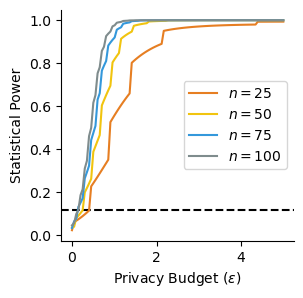

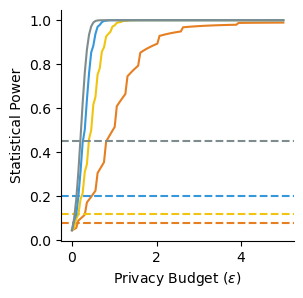

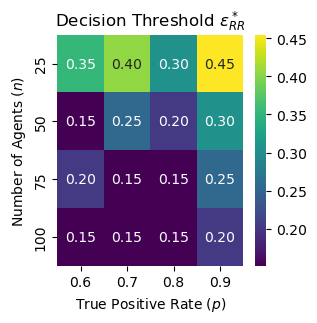

In [42]:
import scipy.stats

def binary_signal_statistical_power_individual(p, alpha):
    if 1 - p < alpha:
        return p + (1 - p) * (alpha - 1 + p) / p
    elif 1 - p == alpha:
        return p
    else:
        return p * alpha / (1 - p)

def binary_signals_statistical_power_rr(n, p, epsilon, alpha=0.05):

    p_eps = 1 / (1 + np.exp(epsilon))

    q = p * p_eps + (1 - p) * (1 - p_eps)

    threshold = scipy.stats.binom.isf(alpha, n, q)
    power =  scipy.stats.binom.sf(threshold, n, 1 - q)
    return power

def decision_threshold_rr(n, p, alpha):
    epsilons = np.linspace(0, 5, 100)

    powers = np.array([binary_signals_statistical_power_rr(n, p, epsilon) for epsilon in epsilons])

    beta_ind = binary_signal_statistical_power_individual(p, alpha)

    # find first epsilon where power is greater than p

    threshold = np.argmin(np.abs(beta_ind - powers))

    return epsilons[threshold]

def plot_decision_thresholds_rr():

    n_range = [25, 50, 75, 100]
    p_range = [0.6, 0.7, 0.8, 0.9]

    decision_thresholds = np.zeros(shape=(len(n_range), len(p_range)))

    for i, n in enumerate(n_range):
        for j, p in enumerate(p_range):
            decision_thresholds[i, j] = decision_threshold_rr(n, p, alpha=0.05)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.heatmap(decision_thresholds, ax=ax, annot=True, fmt='.2f', cmap='viridis')

    ax.set_xticklabels(p_range)
    ax.set_yticklabels(n_range)

    ax.set_xlabel('True Positive Rate ($p$)')
    ax.set_ylabel('Number of Agents ($n$)')

    ax.set_title('Decision Threshold $\epsilon^*_{RR}$')

    fig.savefig('figures/decision_thresholds.pdf', bbox_inches='tight')

def binary_signals_curve_n_rr(p, alpha=0.05):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color='black')

    n_range = [25, 50, 75, 100]

    for i, n in enumerate(n_range):

        epsilons = np.linspace(0, 5, 100)

        powers = np.array([binary_signals_statistical_power_rr(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$n = {n}$', color=palette[i])    

    sns.despine()

    ax.legend()

    # move legend outside
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_n.pdf', bbox_inches='tight')


def binary_signals_curve_p_rr(n, alpha=0.05):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    p_range = [0.6, 0.7, 0.8, 0.9]
    epsilons = np.linspace(0, 5, 100)


    for i, p in enumerate(p_range):

        powers = np.array([binary_signals_statistical_power_rr(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$p  = {p}$', color=palette[i])

        ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color=palette[i])

        # # find intersection point between p and powers
        # intersection = np.argmin(np.abs(p - powers))

        # ax.plot([epsilons[intersection]], [p], 'o', color=palette[i])

    sns.despine()


    # move legend outside
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_p.pdf', bbox_inches='tight')

binary_signals_curve_n_rr(0.7)
binary_signals_curve_p_rr(100)

plot_decision_thresholds_rr()


In [ ]:
def binary_signals_statistical_power_laplace(n, p, epsilon, alpha=0.05, num_iters=10000):

    Delta = np.abs(np.log((1 - p) / p))

    # calculate LRT under H0
    LRTs_H0 = np.zeros(num_iters)
    for i in range(num_iters):
        noise = np.random.laplace(0, 2 * Delta / epsilon, size=(n, 2))

        T = np.random.binomial(n, 1 - p)

        LRTs_H0[i] = T * np.log(p / (1 - p)) + (n - T) * np.log((1 - p) / p) + (noise[:, 0] - noise[:, 1]).sum()

    threshold = np.percentile(LRTs_H0, 100 * (1 - alpha))

    LRTs_HA = np.zeros(num_iters)

    for i in range(num_iters):
        noise = np.random.laplace(0, 2 * Delta / epsilon, size=(n, 2))

        T = np.random.binomial(n, p)

        LRTs_HA[i] = T * np.log(p / (1 - p)) + (n - T) * np.log((1 - p) / p) + (noise[:, 0] - noise[:, 1]).sum()

    power = (LRTs_HA > threshold).mean()
    return power

def decision_threshold_laplace(n, p, alpha=0.05):
    epsilons = np.linspace(0, 5, 100)

    powers = np.array([binary_signals_statistical_power_laplace(n, p, epsilon) for epsilon in epsilons])

    # find first epsilon where power is greater than p

    threshold = np.argmin(np.abs(binary_signal_statistical_power_individual(p, alpha) - powers))

    return epsilons[threshold]

def plot_decision_thresholds_laplace():
    
    n_range = [25, 50, 75, 100]
    p_range =  [0.1, 0.2, 0.3, 0.4]

    decision_thresholds = np.zeros(shape=(len(n_range), len(p_range)))

    for i, n in enumerate(n_range):
        for j, p in enumerate(p_range):
            decision_thresholds[i, j] = decision_threshold_laplace(n, p, alpha=0.05)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.heatmap(decision_thresholds, ax=ax, annot=True, fmt='.2f', cmap='viridis')

    ax.set_xticklabels(p_range)
    ax.set_yticklabels(n_range)

    ax.set_xlabel('True Positive Rate ($p$)')
    ax.set_ylabel('Number of Agents ($n$)')

    ax.set_title('Decision Threshold $\epsilon^*_{Laplace}$')

    fig.savefig('figures/decision_thresholds_laplace.pdf', bbox_inches='tight')

def binary_signals_curve_n_laplace(p, alpha=0.05):
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color='black')

    n_range = [25, 50, 75, 100]

    for i, n in enumerate(n_range):

        epsilons = np.linspace(0, 5, 100)

        powers = np.array([binary_signals_statistical_power_laplace(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$n = {n}$', color=palette[i])    

    sns.despine()

    ax.legend()

    # move legend outside
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_n_laplace.pdf', bbox_inches='tight')

def binary_signals_curve_p_laplace(n, alpha=0.05):
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    p_range = [0.1, 0.2, 0.3, 0.4]
    epsilons = np.linspace(0, 5, 100)


    for i, p in enumerate(p_range):

        powers = np.array([binary_signals_statistical_power_laplace(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$p  = {p}$', color=palette[i])

        ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color=palette[i])

        # # find intersection point between p and powers
        # intersection = np.argmin(np.abs(p - powers))

        # ax.plot([epsilons[intersection]], [p], 'o', color=palette[i])

    sns.despine()

    ax.legend()

    # move legend outside
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_p_laplace.pdf', bbox_inches='tight')

binary_signals_curve_n_laplace(0.7)
binary_signals_curve_p_laplace(100)

plot_decision_thresholds_laplace()


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_874/2108911995.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  noise = np.random.laplace(0, 2 * Delta / epsilon, size=(n, 2))
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_874/2108911995.py:12: RuntimeWarning: invalid value encountered in subtract
  LRTs_H0[i] = T * np.log(p / (1 - p)) + (n - T) * np.log((1 - p) / p) + (noise[:, 0] - noise[:, 1]).sum()
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_874/2108911995.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  noise = np.random.laplace(0, 2 * Delta / epsilon, size=(n, 2))
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_874/2108911995.py:23: RuntimeWarning: invalid value encountered in subtract
  LRTs_HA[i] = T * np.log(p / (1 - p)) + (n - T) * np.log((1 - p) / p) + (noise[:, 0] - noise[:, 1]).sum()
